In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate


from pygsp import graphs, filters, plotting
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm
import scipy
import matplotlib
import utils



import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

# Acquisition

|          | Description                                                  |         Amount |
| -------- | ------------------------------------------------------------ | -------------: |
| nodes    | mice                                                         |      100 - 200 |
| edges    | similar genes, protein expressions, or phenotypes            | O(10) per node |
| features | genes, protein expressions in tissues, or phenotypes         |          1000s |
| labels   | depends: a particular gene, phenotype, or protein expression |            N/A |

## Loading

### genotype_BXD

In [9]:
genotype_df = pd.read_csv("data/genotype_BXD.txt", sep='\t', index_col='SNP')

In [10]:
# Remove F0 and F1 generation (parental)
genotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

In [11]:
genotype_df = genotype_df.transpose()
genotype_df.index.name = 'BXD_strain'

In [12]:
print("There is NaN values: %s" % genotype_df.isna().any().any())

There is NaN values: False


In [819]:
genotype_df.to_pickle("data/pickle/genotype_df.pkl")

### Phenotype

In [55]:
phenotype_df = pd.read_csv("data/Phenotype.txt", sep='\t', index_col='PhenoID')

In [56]:
# Remove F0 and F1 generation (parental)
phenotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

In [57]:
nan_count = phenotype_df.isna().sum().sum()
entries_count = phenotype_df.shape[0] * phenotype_df.shape[1]

print("Number of Nan values: %s" % nan_count)
print("Percentage of nan in the phenotype file: {:0.2f}%".format(nan_count / entries_count * 100))

Number of Nan values: 291981
Percentage of nan in the phenotype file: 61.66%


/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7847: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(Z) > precision


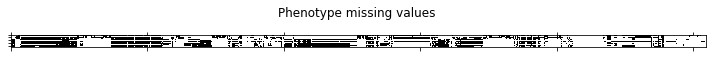

In [18]:
fig, ax = plt.subplots(figsize=(10, 1))
ax.spy(phenotype_df.T)
plt.suptitle("Phenotype missing values")
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.tight_layout()
plt.show()
fig.savefig("phenotype_missing_values.jpg")

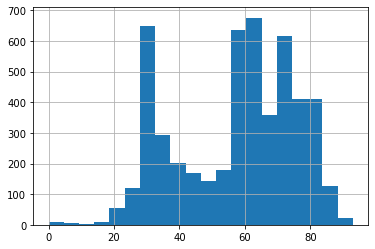

In [43]:
# Let's try to find phenotypes for which the maximum of mice have an entry
phenotype_df.isnull().sum(axis=1).hist(bins=20)

In [44]:
# Select label based on phenotype selection thank to phenotype_id_aligner
labels = phenotype_df.loc[['X62', 'X63', 'X64']].dropna(axis=1)

In [ ]:
phenotype_df.to_pickle("data/pickle/phenotype_df.pkl")

### Gene Expression

In [820]:
#Gene expression
__file__ = "Graph_Analysis_Mice_Genetics.ipynb"
import os
import re

# Build the frame for non sex-related phenotypes
current_path = os.path.dirname(os.path.abspath(__file__))
expr_data_path = os.path.join(current_path, 'data/expression_data/')
files = os.listdir(expr_data_path)
filtered_files = []
pattern = r'Female|Male'
for file in files:
    if re.search(pattern, file):
        continue
    else:
        filtered_files.append(file)

cat = []

for filename in filtered_files[:5]:
    df = pd.read_csv(os.path.join(expr_data_path, filename), sep='\t', index_col=None, header=0)
    cat.append(df)

frame = pd.concat(cat, axis=0, ignore_index=True)
frame.set_index('gene', inplace=True)
# Remove F0 and F1 generation (parental)
frame.drop(['B6D2F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

frame.to_pickle("data/pickle/concat_gene_expression.pkl")

Graph_Analysis_Mice_Genetics.ipynb:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  },


In [821]:
print("Percentage of missing values: %0.2f percent" % (frame.isna().sum().sum() / (frame.shape[0] * frame.shape[1]) * 100))

Percentage of missing values: 52.69 percent


In [824]:
# Keep only genes that are recorded for more than 33 mice
frame_nan_count = frame.isna().sum(axis=1)
filter_frame = frame[frame_nan_count == frame_nan_count.min()]

In [825]:
filter_frame = filter_frame.T

In [831]:
filter_frame.to_pickle("data/pickle/gene_expression_df.pkl")

### Phenotype_id_aligner

In [127]:
phenotype_id_aligner = pd.read_csv('data/phenotypes_id_aligner.txt', sep='\t', encoding='latin1')

phenotype_id_aligner.rename({'Quantitive.trait': 'quantitative_trait'}, axis=1, inplace=True)
quant_pheno_best = phenotype_id_aligner[(phenotype_id_aligner.Strains > 70) & (phenotype_id_aligner.quantitative_trait == 'No')]
quant_pheno_best = quant_pheno_best.sort_values(by='Strains', ascending=False)


## Preprocessing

### Genotype graph

To build our graph, we chose as nodes the mice and as edges a gene based similarity

In [140]:
genotype_df = pd.read_pickle("data/pickle/genotype_df.pkl")

In [829]:
strain_genetic_dist = pdist(genotype_df.values, metric='cosine')

Check the mean pairwise distance  𝔼[𝐷]

In [34]:
def hist_norm_fit(serie: pd.Series, ax: matplotlib.axes.Axes, meth: scipy.stats, bins=30):
    """Print a histogram of a given series and fits a normal pdf to it
    
    Args:
        serie: the data series to plot
        ax: the axis to plot on
        bins: the number of bins for the histograms
        meth: name of the pdf to fit to the data (from scipy)
    """
    # Fit a normal distribution to the data:
    if serie.isnull().values.any():
        mu = np.nanmean(serie.values)
        std = np.nanstd(serie.values)
    else:
        mu, std = meth.fit(serie.values)
    

    # Plot the histogram.
    #dataset.Overall.hist(ax = ax,bins = 30)
    ax.hist(serie, bins=bins, density=True, alpha=0.6, color='m')

    # Plot the PDF.
    xt = ax.get_xticks()
    xmin, xmax = np.min(xt),np.max(xt)

    x = np.linspace(xmin, xmax, 100)
    if meth is norm:
        p = meth.pdf(x, mu, std)
    else:
        p = meth.pdf(x)
    ax.plot(x, p, 'k', linewidth=2)
    title = "Fit results to normal: $\mu$ = %.2f,  $\sigma$ = %.2f" % (mu, std)
    ax.set_title(title)
    
    

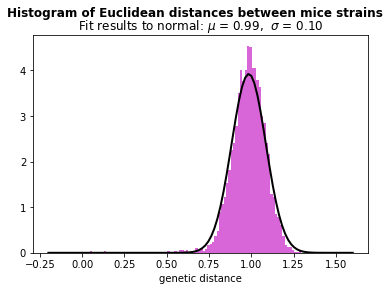

In [35]:
ax = plt.subplot()
plt.suptitle("Histogram of Euclidean distances between mice strains", fontweight='bold')
strain_gen_dist_series = pd.Series(strain_genetic_dist.flatten())
hist_norm_fit(strain_gen_dist_series, ax, meth=norm, bins=100)
ax.set_xlabel("genetic distance")
plt.show()

<div class="alert alert-block alert-info">
    Once we mask the peak below 90, the distances genetic distance between strains looks like a gaussian distribution. Still need to investigate where does this ~90 pick comes from.
</div>

#### Unweighted edges

In [875]:
# Here we take mean distance value when we don't mask over 90
mean_dist = strain_genetic_dist.mean()
std_dist = strain_genetic_dist.std()
print("Mean pairwise distance: %0.2f (+/- %0.2f)" % (strain_genetic_dist.mean(), strain_genetic_dist.std()))

Mean pairwise distance: 0.99 (+/- 0.10)


Let's create adjacency matrix for the strains by thresholding the Euclidean distance matrix.
The resulting **unweighted** adjacency matrix should have entries


$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$


In [866]:
threshold

0.9850168083557959

In [911]:
#Algorithm to create the edges
threshold = mean_dist - 0.125

gen_related_strain_A = squareform(strain_genetic_dist)
gen_related_strain_A = np.where(gen_related_strain_A < threshold, 1, 0)
gen_related_strain_A -= np.identity(gen_related_strain_A.shape[0], dtype='int64')
gen_related_strain_A.shape

(93, 93)

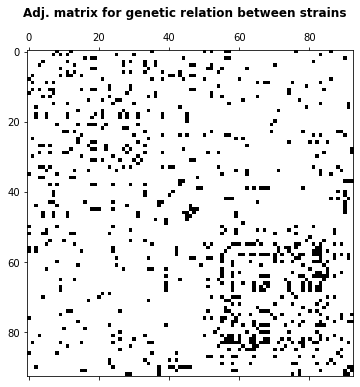

In [912]:
plt.figure(figsize=(6, 6))
plt.spy(gen_related_strain_A)
plt.suptitle("Adj. matrix for genetic relation between strains", fontweight='bold')
plt.show()

In [913]:
np.save("data/numpy/gen_related_strain_A.npy", gen_related_strain_A)

#### Weighted edges

In [137]:
# def epsilon_similarity_graph(X: np.ndarray, metric='euclidean', sigma=1, epsilon=0):
#     """ X (n x d): coordinates of the n data points in R^d.
#         sigma (float): width of the kernel
#         epsilon (float): threshold
#         Return:
#         adjacency (n x n ndarray): adjacency matrix of the graph.
#     """
#     Dists = squareform(pdist(X,metric = "euclidean"))
#     Dists = np.exp(-Dists**2/(2 * sigma**2))
#     Dists[Dists <= epsilon] = 0
#     np.fill_diagonal(Dists,0)
#     return Dists

In [138]:
def plot_distrib(adjacency):
    """ Plot the density of kerneled distances
    
    Args: 
        adjacency (np.array): adjacency matrix
        
    """
    non_zero = adjacency[np.nonzero(adjacency)]
    print("{:0.2f} % of the original data is kept".format(non_zero.size / adjacency.size * 100))
    plt.plot(np.sort(non_zero)[::-1])

In [144]:
def build_adj_from_strain(genotype_df, strains, metric, sigma, epsilon):
    """ Build adjacency matrix using whole data filtered by the strains parameter """
    
    filtered_df = genotype_df[genotype_df.index.isin(strains)]
    filtered_df.sort_index(inplace=True)
    adj = epsilon_similarity_graph(filtered_df.values, \
                                   metric=metric, sigma=70, epsilon=0.273)
    return adj

In [ ]:
# def build_adj_from_strain(genotype_df, strains, metric, sigma, epsilon):
#     """ Build adjacency matrix using whole data filtered by the strains parameter """
    
#     filtered_df = genotype_df[genotype_df.index.isin(strains)].copy()
#     filtered_df.sort_index(inplace=True)
#     adj = epsilon_similarity_graph(filtered_df.values, \
#                                    metric=metric, sigma=sigma, epsilon=epsilon)
#     return adj

In [32]:
gene_expression_df = pd.read_pickle("data/pickle/gene_expression_df.pkl")
signal = pd.read_pickle("data/pickle/top_variance_genes.pkl")
signal = gene_expression_df[signal.index]

In [ ]:
adjacency = build_adj_from_strain(genotype_df, gene_expression_df.index, 'cosine', 70, 0.273)

12.23 % of the original data is kept


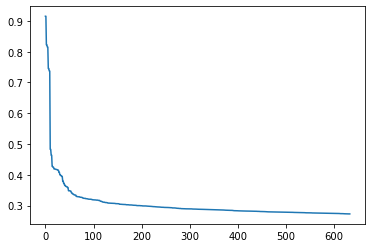

In [49]:
plot_distrib(adjacency)

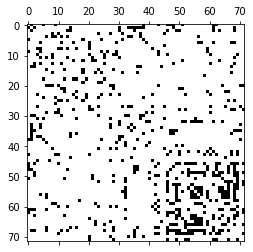

In [50]:
plt.spy(adjacency)
plt.show()

In [51]:
np.save("data/numpy/weighted_adjacency.npy", adjacency) 

# Exploration

## Gene graph

In [970]:
# Loading adjacency matrix
A_genes = np.load("data/numpy/gen_related_strain_A.npy")
gene_graph = nx.from_numpy_array(A_genes)

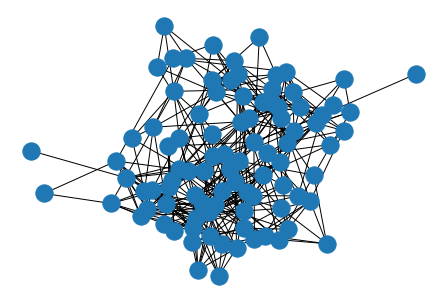

In [971]:
nx.draw(gene_graph)

### Basic statistics

In [142]:
from tabulate import tabulate
def graph_basic_stats(G):
    """ Print basic stats for a nx.Graph()"""
    nodes_number = G.number_of_nodes()
    edges_number = G.number_of_edges()

    g_degree = G.degree()
    sum_degree = sum(dict(g_degree).values())
    average_degree = sum_degree / nodes_number

    tab = [
        ["Number of nodes", nodes_number],
        ["Number of edges", edges_number],
        ["Graph density", round(nx.classes.function.density(G) * 100, 2)],
        ["Average degree", round(average_degree, 2)],
        ["Number of connected components", nx.number_connected_components(G)],
        ["Average clustering coefficient", round(nx.average_clustering(G), 2)],
        ["Diameter of the network (longest shortest path)", nx.diameter(G)]   
    ]
    print(tabulate(tab, tablefmt='fancy_grid'))
    
graph_basic_stats(gene_graph)

NameError: name 'gene_graph' is not defined

In [27]:
graph_basic_stats(gene_graph)

NameError: name 'graph_basic_stats' is not defined

### Degree distribution

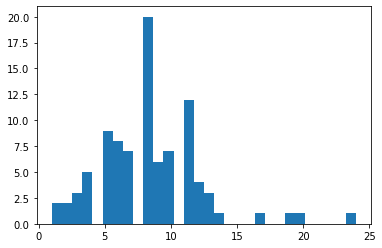

In [973]:
def plot_hist(G, bins=30):
    d = G.degree()
    plt.hist(list(dict(d).values()), bins=bins)
    plt.show()
    
plot_hist(gene_graph)

### Spectral analysis 

#### Eigenvalues & Eigenvectors

In [10]:
adjacency = np.load("data/numpy/weighted_adjacency.npy")
pygsp_weighted_graph = graphs.Graph(adjacency, 'normalized')
nx_weighted_graph = nx.Graph(adjacency)

In [1066]:
pygsp_weighted_graph.compute_fourier_basis()

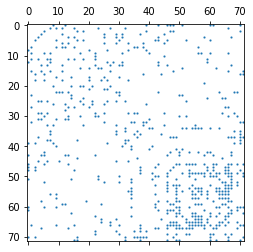

In [1067]:
ax = plt.subplot()
ax.spy(pygsp_weighted_graph.W, markersize=1)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


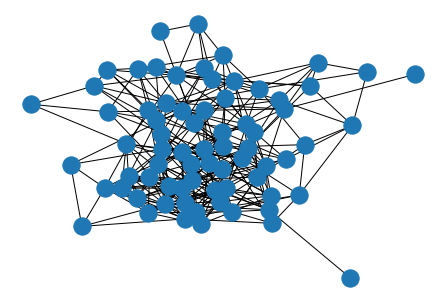

In [1068]:
nx.draw(nx_weighted_graph)

In [1070]:
graph_basic_stats(nx_weighted_graph)

╒═════════════════════════════════════════════════╤════════╕
│ Number of nodes                                 │  72    │
├─────────────────────────────────────────────────┼────────┤
│ Number of edges                                 │ 317    │
├─────────────────────────────────────────────────┼────────┤
│ Graph density                                   │  12.4  │
├─────────────────────────────────────────────────┼────────┤
│ Average degree                                  │   8.81 │
├─────────────────────────────────────────────────┼────────┤
│ Number of connected components                  │   1    │
├─────────────────────────────────────────────────┼────────┤
│ Average clustering coefficient                  │   0.27 │
├─────────────────────────────────────────────────┼────────┤
│ Diameter of the network (longest shortest path) │   5    │
╘═════════════════════════════════════════════════╧════════╛


In [1071]:
# Laplacian
laplacian_matrix = nx.normalized_laplacian_matrix(nx_weighted_graph)
lamb_norm = nx.normalized_laplacian_spectrum(nx_weighted_graph)

Text(0.5, 1.0, 'Eigenvalues $L_{norm}$')

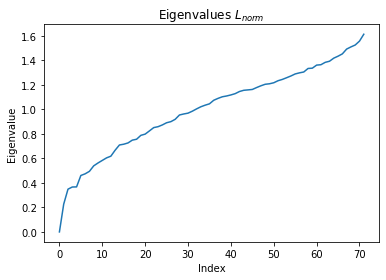

In [1072]:
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')

# Exploitation

## Preprocessing

### Labels (hait coat color)

In [8]:
# Build the target
phenotype_df = pd.read_pickle("data/pickle/phenotype.pkl")
y = phenotype_df.loc['X62'].dropna().astype('int64')

### Find interesting signal

In [199]:
gene_expression_df = pd.read_pickle("data/pickle/gene_expression_df.pkl")

top_var = 30
top_var_gene = gene_expression_df.std().sort_values().tail(top_var)

In [1075]:
top_var_gene.to_pickle("data/pickle/top_variance_genes.pkl")

### Graph signal processing (hand crafted)

In [1076]:
lam = pygsp_weighted_graph.e
U = pygsp_weighted_graph.U

In [1088]:
gene_expression_df = pd.read_pickle("data/pickle/gene_expression_df.pkl")
signal = pd.read_pickle("data/pickle/top_variance_genes.pkl")
signal = gene_expression_df[signal.index]
# signal.replace({np.nan: 0}, inplace=True)

In [1089]:
signal.interpolate()

gene,Mup2_10513437,Ube2g1_10342768,Mup2_10513455,Mup7_10513420,Ube2g1_10343119,Fbxw11_10375123,Dlg1_10338109,Fbxw11_10375121,H2-Ea-ps_10450161,Mela_10582545
BXD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD100,5.812,7.626,5.791,6.151,8.434,11.691,8.131,11.802,6.517,7.187
BXD101,6.260,5.005,6.183,6.585,4.471,8.518,8.082,8.531,6.810,9.852
BXD11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
BXD9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD90,6.388,6.113,6.416,6.802,6.107,7.867,4.913,7.899,5.990,10.308
BXD95,5.275,5.385,5.123,5.478,5.612,11.583,5.070,11.735,6.090,9.969
BXD98,6.940,5.482,6.824,7.226,5.587,11.901,7.657,12.044,6.594,9.686


Text(0, 0.5, 'GFT')

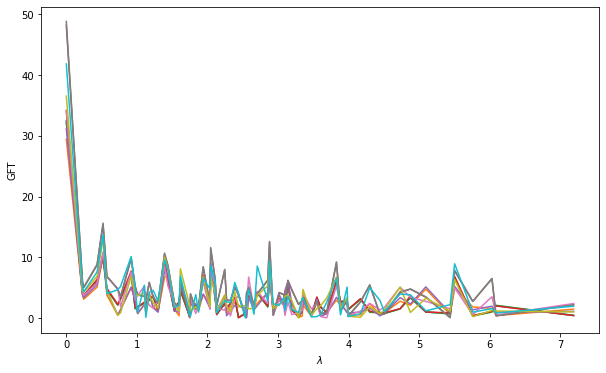

In [1079]:
plt.figure(figsize=(10, 6))
for i in range(signal.shape[1]):
    plt.plot(lam, abs(pygsp_weighted_graph.gft(signal.iloc[:, i].values)), '-') 
    
plt.xlabel('$\lambda$')
plt.ylabel('GFT')

In [1086]:
sign_filtered = filters.Expwin(pygsp_weighted_graph, bmax=0.2).filter(signal)

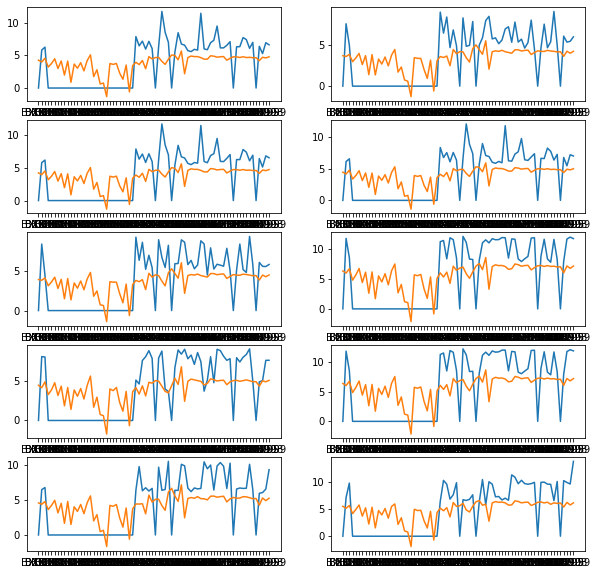

In [1087]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    ax.plot(signal.iloc[:,idx])
    ax.plot(sign_filtered[:, idx])

In [126]:
fig.savefig("filtered_signal.png")

### Interpolation error measure

In [755]:
def kfold_interp_error(val, filter_, k=10, test_size=0.1):
    ''' Compute the error of interpolation with kfold for each column of the DataFrame
    
    Args:
        - df (pd.DataFrame): dataframe where rows are mouse strains and column are gene expression
        - filter_ (pygsp.filters): any pygsp filter
        - k (integer): the number of folding for each column
        - test_size (float): percentage of the strains to use as test set for error measurment
    Return:
        - kFold_abs_err_list (list()): the list of k-folded absolute error for each column (gene expression)
    '''
    
    kFold_abs_err_list = []
    
    for i in range(val.shape[1]):
        
        err_list = []
        non_zero_idx = np.where(val[:,i] != 0.)
        for j in range(k):
            s_copy = np.copy(val[:,i])
            idx_test = np.random.choice(non_zero_idx[0], size=int(s.shape[0] * test_size), replace=False)

            np.put(s_copy, idx_test, 0.)

            s_filtered = filter_.filter(s_copy)
            err = val[idx_test,i].sum() - s_filtered[idx_test].sum()
            err_list.append(err)
        
        kFold_abs_err_list.append(np.mean(err_list))
    return kFold_abs_err_list

In [818]:
pygsp_filter = filters.Expwin(pygsp_weighted_graph, bmax=0.8)
%time kFold_abs_err_list = kfold_interp_error(signal.values, pygsp_filter, test_size=0.1)

mean_err = np.mean(kFold_abs_err_list)
print("Mean absolute interpolation error for the gene expression: {}".format(mean_err))

CPU times: user 522 ms, sys: 7.87 ms, total: 530 ms
Wall time: 536 ms
Mean absolute interpolation error for the gene expression: 25.063579600767813


In [779]:
%%time
# find the best parameters for Expwin

mean_err_list = []
for i in np.linspace(0.01, 1.2, num=10):
    pygsp_filter = filters.Expwin(pygsp_weighted_graph, bmax=0.8)
    assess = []
    for j in range(50):
        assess.append(kfold_interp_error(signal.values, pygsp_filter, test_size=0.1))
    
    mean_err_list.append(np.mean(np.mean(assess)))

## Collective classification

In [3]:
adjacency = np.load("data/numpy/weighted_adjacency.npy")
genotype_gene_expression_present_df = pd.read_pickle("data/pickle/gene_expression_df.pkl")
pygsp_weighted_graph = graphs.Graph(adjacency, 'normalized')
nx_weighted_graph = nx.Graph(adjacency)

In [4]:
# Set strain name to node
strains_list = genotype_gene_expression_present_df.index.tolist()
mapping = dict(zip(range(len(strains_list)), strains_list))

In [5]:
nx.set_node_attributes(nx_weighted_graph, mapping, name='strain')

**Markov Assumption**:\
the label $Y_i$ of one node $i$ depends on the labels of its neighbors $N_i$:\
$P(Y_i|i) = P(Y_i|N_i)$ 

### Probabilistic relational classifier

**Basic idea:** Class probability of 𝑌𝑖 is a weighted
average of class probabilities of its neighbors\
**Labeled nodes:** initialize with ground-truth 𝑌
labels\
**Unlabeled nodes:** initialize 𝑌 uniformly\
**Update:** all nodes in a random order until
convergence or until maximum number of iterations
is reached

#### Node labelling

In [245]:
# Build the target
phenotype_df = pd.read_pickle("data/pickle/phenotype.pkl")
y = phenotype_df.loc['X62'].dropna().astype('int64')
y = y[genotype_gene_expression_present_df.index]

#### relational_classifier()

In [312]:
def masking(y, prop=0.5, rs=None):
    ''' Set to np.nan masked values
    
    Params:
        - y (pd.Series): the gene expression to create train/test 
        - prop (float): the proportion of nodes to mask as test set
        
    Returns:
        - tmp (pd.Series): the masked to np.nan series
        - mask (np.ndarray): the mask that created the series
    '''
    
    tmp = y.values.astype('float').copy()
    # random label masking
    m = None
    if rs is None:
        m = np.random.uniform(0, 1, len(nx_weighted_graph.node)) > prop
    else:
        rs = np.random.RandomState(42)
        m = rs.uniform(0, 1, len(nx_weighted_graph.node)) > prop
    tmp[~m] = np.nan
    return tmp, m

def init(y_masked, cat=4):
    ''' Initialize the probabilities for each node (1 for non-nan nodes and 1/#cat for np.nan ones)
    
    Params:
        - y_masked (pd.Series): a masked series
        
    Returns:
        - prob_mat (np.ndarray): a probability matrix that initialized to 
            1 for not masked data at the mouse label and 1/(# of categories) for the
            the masked data.
        
    '''
    
    a = y_masked.copy()
    # Unique categories

    # Probabily matrix
    prob_mat = np.zeros((a.shape[0], cat), dtype='float')
    # Vector to fill nan values
    nan_unif_val = np.array([1 / cat] * cat)
    # Replace nan values
    prob_mat[np.isnan(a), :] = nan_unif_val
    # One hot encode non-nan values to get a probability of one
    valid_val = ~np.isnan(a)
    a[valid_val] = a[valid_val]
    b = np.zeros((a[valid_val].shape[0], cat))
    b[np.arange(a[valid_val].shape[0], dtype='int'), a[valid_val].astype('int')-1] = 1
    prob_mat[valid_val, : ] = b
    
    return prob_mat

def update(G, p_m, max_iter):
    ''' Update the label probability matrix for each masked node and let to 1 for the training
        mice.
    
    Parameters:
        - G (nx.Graph): a graph
        - p_m (np.ndarray): a node label probability matrix
        - max_iter (int): the number of iteration of the update step
    
    '''
    
    p_mat = p_m
    proba_dict = dict(enumerate(p_mat))
    nx.set_node_attributes(G, proba_dict, name='probabilities')
    G_nodes = G.nodes
    G_edges = G.edges
    for i in range(max_iter):
        update_counter = 0
        for node in G.nodes():
            p_update = {}
            update_step(G, G_nodes, G_edges, node, p_update)
            nx.set_node_attributes(G, p_update, name='probabilities')
        if update_counter >= max_iter:
            break

def update_step(G, G_nodes, G_edges, node, p_update):
    """ Update the probability matrix accoring to nodes first neighbors"""
    if G_nodes[node]['probabilities'].max() != 1.: 
        W = 0
        sum_W_x_P = 0
        for neighbor in G.neighbors(node):
            W_ij = G.edges[node, neighbor]['weight']
            W += W_ij
            sum_W_x_P += W_ij * G_nodes[neighbor]['probabilities']
        p_update[node] = sum_W_x_P / W
    else: 
        p_update[node] = G_nodes[node]['probabilities']
    return p_update

In [27]:
from sklearn.metrics import classification_report, accuracy_score
def relational_classifier(G, y_masked, max_iter=100):
    """ classify the set where there is nan values
    
    Parameters:
        - G (nx.Graph): a Graph
        - y (pd.Series): the label to predict
        - max_iter (int): the number of iteration of the update
        - prop (float): percentage of test set
    """
    G_cop = G.copy()
    p_mat = init(y_masked)
    proba_dict = dict(enumerate(p_mat))
    nx.set_node_attributes(G, proba_dict, name='probabilities')
    update(G, p_mat, max_iter=100)
    updated_p_mat = np.concatenate(list(nx.get_node_attributes(G, 'probabilities').values())).reshape(-1, 4)
    y_pred = np.argmax(updated_p_mat, axis=1) + 1
    return y_pred



In [1]:
%load_ext line_profiler

In [80]:
def bootstrap_classification(div=10, boot_num=1):
    """ Run the classification process """
    scores = []
    for p in np.linspace(0, 0.8, div):
        bootstrap = []
        for i in range(boot_num):
            y_masked, mask = masking(y, p)
            y_pred = relational_classifier(nx_weighted_graph, y_masked, 100)
            acc_score = accuracy_score(y[~mask], y_pred[~mask])
            bootstrap.append(acc_score)
        scores.append(np.mean(bootstrap))
    return scores       
                      

In [316]:
scores = bootstrap_classification(div=40, boot_num=10)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [320]:
with open('data/results/relational_classifier_scorre.csv', 'w') as filehandle:
    for score in scores:
        filehandle.write('%s\n' % score)

In [340]:
scores = []
with open('data/results/relational_classifier_scorre.csv', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        if line[:-1] != 'nan':
            currentPlace = float(line[:-1])

            # add item to the list
            scores.append(currentPlace)

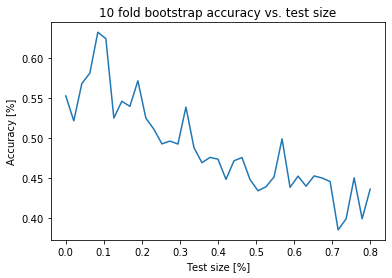

In [344]:
plt.plot(np.linspace(0, 0.8, 39), scores)
plt.title("10 fold bootstrap accuracy vs. test size")
plt.xlabel("Test size [%]")
plt.ylabel("Accuracy [%]")
plt.show()

As we can see, with the genetic graph, we are already able to predict 55% with 80% of the data as model and prediction on 20%. If the choice was random, we would have 25% (one out of four) of correct prediction. It means that this simple algorithm is already able to learn some patterns.

### Graph Convolutional Network (GCN)

In [2]:
gcn_message = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [3]:
# # Define the message and reduce function
# def gcn_message(edges):
#     # The argument is a batch of edges.
#     # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
#     return {'msg' : edges.src['h']}

# def gcn_reduce(nodes):
#     # The argument is a batch of nodes.
#     # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
#     return {'h' : th.sum(nodes.mailbox['msg'], dim=1)}

In [4]:
# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [5]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs.float())
        h = th.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 30 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.

In [6]:
# Build the target
genotype_gene_expression_present_df = pd.read_pickle("data/pickle/genotype_gene_expression_present_df.pkl")
phenotype_df = pd.read_pickle("data/pickle/phenotype.pkl")
y = phenotype_df.loc['X62'].dropna().astype('int64')
y = y[genotype_gene_expression_present_df.index]

In [7]:
# Build the relevant high variance signals
gene_expression_df = pd.read_pickle("data/pickle/gene_expression_df.pkl")
top_var = 30
top_var_gene = gene_expression_df.std().sort_values().tail(top_var)
signal = gene_expression_df[top_var_gene.index]

In [8]:
# What are the most present labels ?
y.value_counts()

1    25
4    17
3    16
2    14
Name: X62, dtype: int64

In [9]:
# Select only the mice that have label 1 or 4. We chose it because they are the most present
y_binary = y[(y.values == 1) | (y.values == 4)]

In [10]:
# Drop the rows with only nan values
sign = signal[signal.index.isin(y_binary.index)].dropna(how='all')

In [11]:
# Filter y_binary to take into account nan filtering
y_binary = y_binary[y_binary.index.isin(sign.index)]

In [12]:
# Are both index the same ?
(y_binary.index == sign.index).all()

True

In [13]:
# Transfrom to np.array
sign_np = sign.values
y_b = y_binary.values

In [14]:
inputs = th.tensor(sign_np)

In [15]:
import random
# Select randomly which node to use as first labeled nodes 
# !!! idea: chose the best one based on graph properties !!!

one_node_labeled = np.random.choice(np.where(y_b == 1)[0])
four_node_labeled = np.random.choice(np.where(y_b == 4)[0])
print(one_node_labeled, four_node_labeled)
print("y_b[one_node_labeled]: %i, y_b[four_node_labeled]: %i" % (y_b[one_node_labeled], y_b[four_node_labeled]))

3 1
y_b[one_node_labeled]: 1, y_b[four_node_labeled]: 4


In [16]:
# Assign the labels both randomely selected nodes
labeled_nodes = th.tensor([one_node_labeled, four_node_labeled]) ## 
labels = th.tensor([0, 1])

In [17]:
# Build a graph adjacency for the subsample and mice labeled as 1 and 4
genotype_df = pd.read_pickle('data/pickle/genotype_df.pkl')
adj = utils.build_adj_from_strain(genotype_df, sign.index, 'cosine', 70, 0.273)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


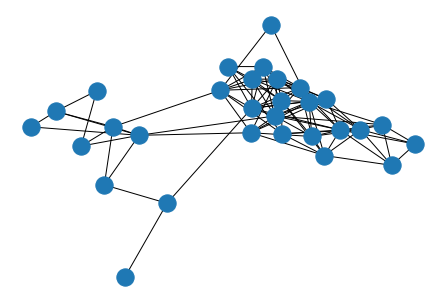

In [18]:
nx.draw(nx.from_numpy_array(adj))

In [20]:
utils.graph_basic_stats(nx.from_numpy_array(adj))

╒═════════════════════════════════════════════════╤════════╕
│ Number of nodes                                 │  30    │
├─────────────────────────────────────────────────┼────────┤
│ Number of edges                                 │ 106    │
├─────────────────────────────────────────────────┼────────┤
│ Graph density                                   │  24.37 │
├─────────────────────────────────────────────────┼────────┤
│ Average degree                                  │   7.07 │
├─────────────────────────────────────────────────┼────────┤
│ Number of connected components                  │   1    │
├─────────────────────────────────────────────────┼────────┤
│ Average clustering coefficient                  │   0.49 │
├─────────────────────────────────────────────────┼────────┤
│ Diameter of the network (longest shortest path) │   5    │
╘═════════════════════════════════════════════════╧════════╛


In [21]:
G = DGLGraph(adj)

In [36]:
net = GCN(sign_np.shape[1], 2, 2)

In [47]:
logits = net(G, inputs)
all_logits.append(logits.detach())
logp = F.log_softmax(logits, 1)
logp
# we only compute loss for labeled nodes
# loss = F.nll_loss(logp[labeled_nodes], labels)

# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

tensor([[-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389],
        [-1.0350, -0.4389]], grad_fn=<LogSoftmaxBackward>)

In [38]:
optimizer = th.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 12.6219
Epoch 1 | Loss: 56.2387
Epoch 2 | Loss: 13.5176
Epoch 3 | Loss: 15.9784
Epoch 4 | Loss: 20.6892
Epoch 5 | Loss: 22.4937
Epoch 6 | Loss: 22.4191
Epoch 7 | Loss: 20.9773
Epoch 8 | Loss: 18.5908
Epoch 9 | Loss: 15.6004
Epoch 10 | Loss: 12.2780
Epoch 11 | Loss: 8.8368
Epoch 12 | Loss: 5.4388
Epoch 13 | Loss: 2.2040
Epoch 14 | Loss: 0.5182
Epoch 15 | Loss: 0.7299
Epoch 16 | Loss: 0.7317
Epoch 17 | Loss: 0.7332
Epoch 18 | Loss: 0.7345
Epoch 19 | Loss: 0.7356
Epoch 20 | Loss: 0.7365
Epoch 21 | Loss: 0.7372
Epoch 22 | Loss: 0.7377
Epoch 23 | Loss: 0.7380
Epoch 24 | Loss: 0.7382
Epoch 25 | Loss: 0.7383
Epoch 26 | Loss: 0.7382
Epoch 27 | Loss: 0.7381
Epoch 28 | Loss: 0.7378
Epoch 29 | Loss: 0.7374


/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


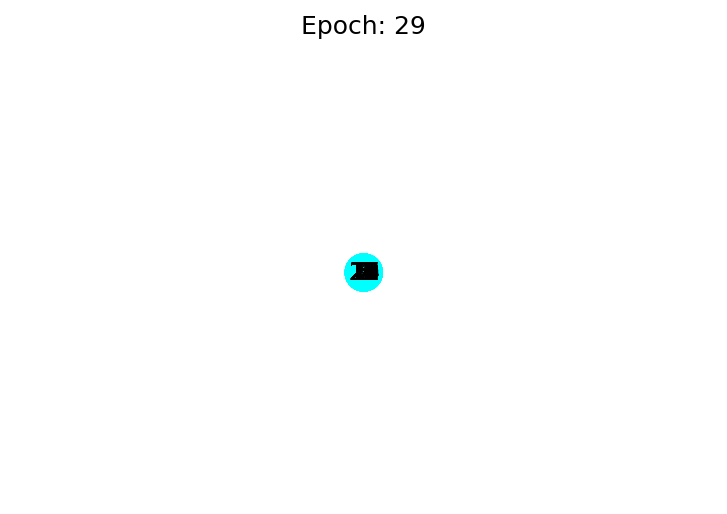

In [26]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline

nx_G = G.to_networkx().to_undirected()

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(30):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(29)  # draw the prediction of the first epoch
# plt.close()

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


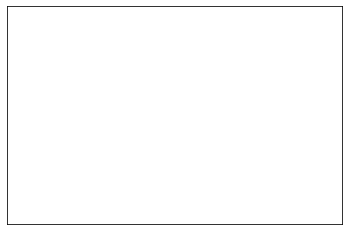

In [27]:
from IPython.display import HTML
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_jshtml())

SyntaxError: 'return' outside function (<ipython-input-39-fb00a25b1075>, line 13)

In [45]:
train_mask

tensor([1, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8)